In [3]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import utils

In [10]:
# Can't do motifs because graphs are undirected.

# How do different algorithms rank node centrality?
# Do networks have similar clustering?


# Graph Properties

In [ ]:
G = utils.get_brain_graphs(1)[0]

In [70]:
G.nodes['1']

{'dn_position_x': 37.8125,
 'dn_position_y': 73.7291666667,
 'dn_position_z': 7.79166666667,
 'dn_correspondence_id': '1',
 'dn_region': 'cortical',
 'dn_fsname': 'lateralorbitofrontal_9',
 'dn_name': 'rh.lateralorbitofrontal_9',
 'dn_hemisphere': 'right'}

In [71]:
G.edges[('3', '504')]

{'fiber_length_mean': 13.3205075264,
 'FA_mean': 0.188619064167,
 'number_of_fibers': 20.625}

# Single Graph Visualization

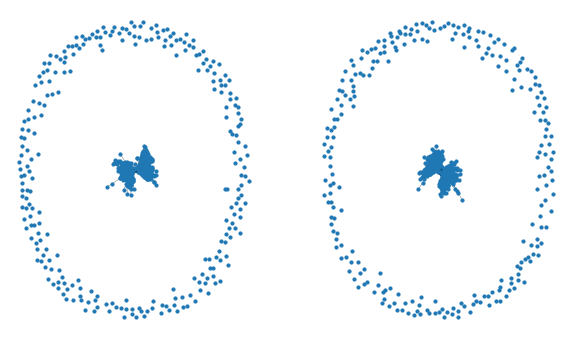

In [50]:
# Draw a few of the networks
G1, G2 = utils.get_brain_graphs(2)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(G1, node_size=10, width=0.25, ax=axes[0])
nx.draw(G2, node_size=10, width=0.25, ax=axes[1])

# There are many nodes with degree 0!

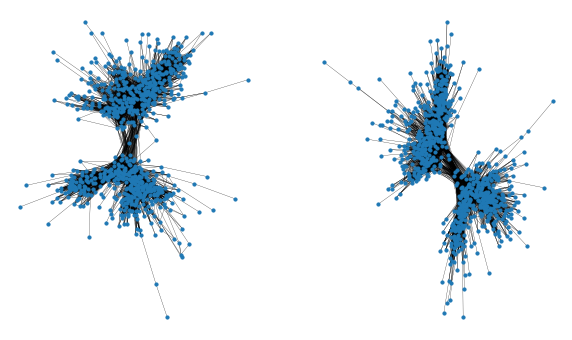

In [52]:
# Draw the largest connected components only
def get_lcc(G):
    largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc)

LCC1, LCC2 = get_lcc(G1), get_lcc(G2)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(LCC1, node_size=10, width=0.25, ax=axes[0])
nx.draw(LCC2, node_size=10, width=0.25, ax=axes[1])

# Structure is pretty clear based on this graph.
# You can see the two hemispheres!

# Degree Distributions

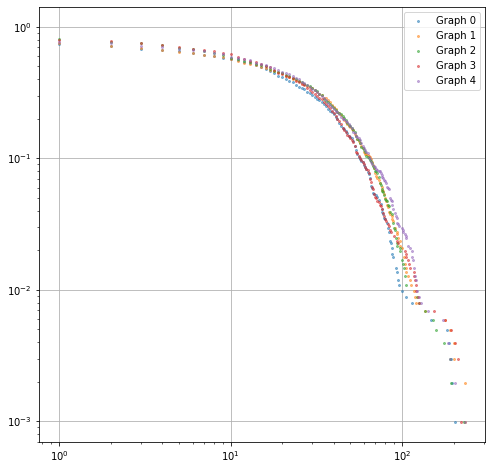

In [26]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_ccdf(G, label):
    # Get the degree of each node
    degree_sequence = [d for n, d in G.degree()]
    # Perform linear binning
    degree_counts = Counter(degree_sequence)
    deg, cnt = zip(*sorted(degree_counts.items()))
    deg, cnt = np.array(deg), np.array(cnt)
    prob = cnt / sum(cnt)
    # Complementary Cumulative Distribution Function
    loglog_args = {'ls': '', 'marker': 'o', 'markersize': 2, 'alpha': 0.5}
    ccdf = np.cumsum(prob[::-1])[::-1]
    plt.loglog(deg, ccdf, label=label, **loglog_args)

graphs = utils.get_brain_graphs(5)
fig = plt.figure(figsize=(8,8))
for i, G in enumerate(graphs):
    plot_degree_ccdf(G, f'Graph {i}')
plt.legend()
plt.grid()

# Expanding on this: 
# Plot curves for power-law distributions with alpha=2 and alpha=3
# Fit power-law distributions to the data

# Degree Correlations

Text(0, 0.5, 'Number of Graphs')

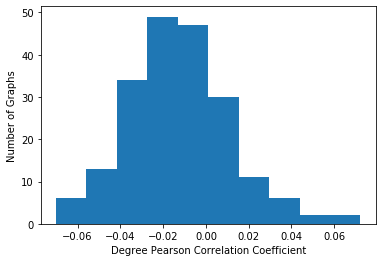

In [41]:
# Check out the distribution of degree correlations
pccs = []
graphs = utils.get_brain_graphs(200)
for G in graphs:
    r = nx.degree_pearson_correlation_coefficient(G)
    pccs.append(r)
_ = plt.hist(pccs)
plt.xlabel("Degree Pearson Correlation Coefficient")
plt.ylabel("Number of Graphs")

# Looks like these networks tend to be ever so slightly 
# dissortative, but there is quite a bit of diversity 
# and some networks tend to be more assortative.

# Distribution of Clustering Coefficients

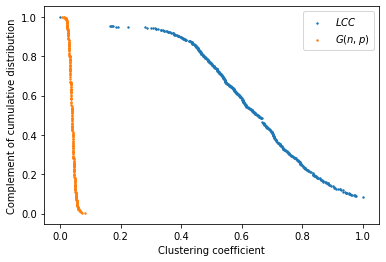

In [60]:
# Get the largest connected component
G = utils.get_brain_graphs(1)[0]
LCC = get_lcc(G)
# Generate a comparable Gnp random graph
n = len(LCC.nodes())
p = len(LCC.edges()) / (1/2*n*(n-1))
Gnp = nx.fast_gnp_random_graph(n, p, seed=0)

def plot_ccoeff_ccdf(G, label=''):
    data = sorted(nx.clustering(G).values())
    counts = Counter(data)
    ccoeffs, counts = zip(*sorted(counts.items()))
    ccoeffs, counts = np.array(ccoeffs), np.array(counts)
    probs = counts / sum(counts)
    ccdf = np.cumsum(probs[::-1])[::-1]
    plt.scatter(ccoeffs, ccdf, s=2, label=label)

plot_ccoeff_ccdf(LCC, label='$LCC$')
plot_ccoeff_ccdf(Gnp, label='$G(n,p)$')
plt.legend()
plt.xlabel('Clustering coefficient')
_ = plt.ylabel('Complement of cumulative distribution')

# Much higher clustering coefficient than a comparable G(n,p) network

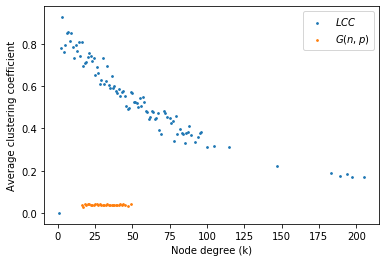

In [61]:
def plot_ccoeff_vs_degree(graph, label=None):
    nodes = graph.nodes()
    ccoeffs = nx.clustering(graph)
    ccoeffs = np.array([ccoeffs[n] for n in nodes])
    degrees = nx.degree(graph)
    degrees = np.array([degrees[n] for n in nodes])
    unique_degrees = sorted(np.unique(degrees))
    mean_coeffs = []
    for k in unique_degrees:
        mean_coeffs.append(np.average(ccoeffs[np.where(degrees==k)]))
    plt.scatter(unique_degrees, mean_coeffs, s=3, label=label)

plot_ccoeff_vs_degree(LCC, label='$LCC$')
plot_ccoeff_vs_degree(Gnp, label='$G(n,p)$')
plt.legend()
plt.xlabel('Node degree (k)')
_ = plt.ylabel('Average clustering coefficient')

# The above visualization shows that  LCC  generally has more nodes 
# of high degree and larger clustering coefficients than the  Gnp  
# graph for nodes of the same degree. We can also see the expected 
# decline in clustering coefficient for nodes of high degree.

# Centrality

In [117]:
# Draw a few of the networks
G1, G2 = utils.get_brain_graphs(2)
LCC1, LCC2 = get_lcc(G1), get_lcc(G2)
# Make layouts the same between plots
pos1 = nx.spring_layout(LCC1, weight='fiber_length_mean')
pos2 = nx.spring_layout(LCC2, weight='fiber_length_mean')

In [118]:
def get_ordered_closeness(G):
    closeness = nx.closeness_centrality(G, distance='fiber_length_mean')
    ordered = [closeness[n] for n in G.nodes()]
    return ordered

close1 = get_ordered_closeness(LCC1)
close2 = get_ordered_closeness(LCC2)

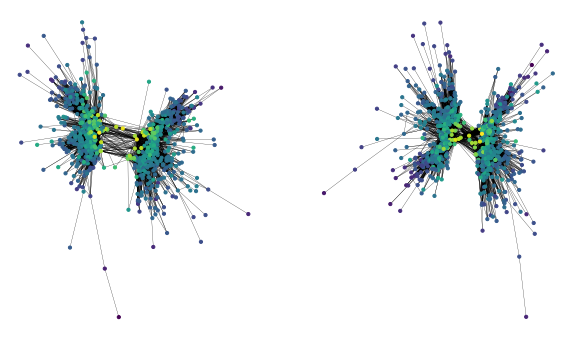

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(LCC1, node_size=10, width=0.25, pos=pos1, node_color=close1, ax=axes[0])
nx.draw(LCC2, node_size=10, width=0.25, pos=pos2, node_color=close2, ax=axes[1])

# We can calculate closeness centrality based on the mean fiber length
# between each node. This centrality is more related to the anatomical
# centrality of nodes.

In [120]:
def get_ordered_betweenness(G):
    betweenness = nx.betweenness_centrality(G, weight='number_of_fibers')
    ordered = [betweenness[n] for n in G.nodes()]
    return ordered

btwn1 = get_ordered_betweenness(LCC1)
btwn2 = get_ordered_betweenness(LCC2)

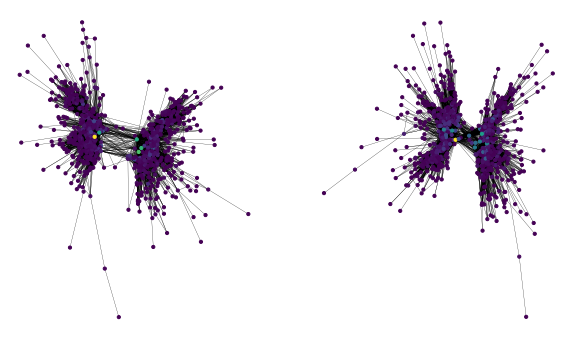

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(LCC1, node_size=10, width=0.25, pos=pos1, node_color=btwn1, ax=axes[0])
nx.draw(LCC2, node_size=10, width=0.25, pos=pos2, node_color=btwn2, ax=axes[1])

# A very small number of nodes have a very high betweenness centrality!
# Most of the communication goes through very through nodes. This 
# centrality metric is more related to the functional centrality of nodes.

# Brain Areas and Clustering

In [122]:
# Draw a few of the networks
G1, G2 = utils.get_brain_graphs(2)
LCC1, LCC2 = get_lcc(G1), get_lcc(G2)
# Make layouts the same between plots
pos = nx.spring_layout(G1)
# Get ground-truth labels / colors

# fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# nx.draw(LCC1, node_size=10, width=0.25, ax=axes[0])
# nx.draw(LCC2, node_size=10, width=0.25, ax=axes[1])

In [123]:
def get_attribute_color(G, attr):
    attrs = nx.get_node_attributes(G, attr)
    cats = sorted(set(attrs.values()))
    cat2val = dict(zip(cats, np.linspace(0, 1, len(cats))))
    vals = [cat2val[attrs[n]] for n in G.nodes()]
    return vals

hemi1 = get_attribute_color(LCC1, 'dn_hemisphere')
hemi2 = get_attribute_color(LCC2, 'dn_hemisphere')

# # Get node properties - nodes are the same across graphs
# region1 = order_dict(nx.get_node_attributes(LCC1, 'dn_region'))
# fsname = order_dict(nx.get_node_attributes(LCC1, 'dn_fsname'))
# hemispheres = order_dict(nx.get_node_attributes(LCC1, 'dn_hemisphere'))

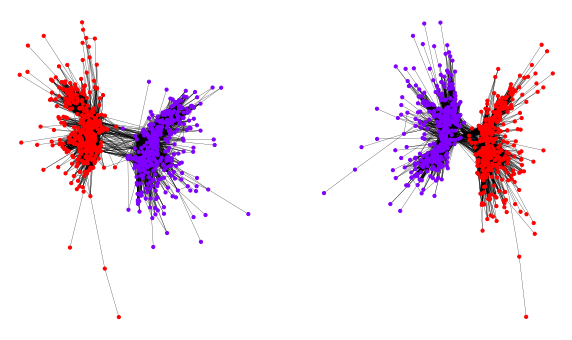

In [124]:
hemi1 = get_attribute_color(LCC1, 'dn_hemisphere')
hemi2 = get_attribute_color(LCC2, 'dn_hemisphere')

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(LCC1, node_size=10, width=0.25, pos=pos1, node_color=hemi1, ax=axes[0], cmap=plt.cm.rainbow)
nx.draw(LCC2, node_size=10, width=0.25, pos=pos2, node_color=hemi2, ax=axes[1], cmap=plt.cm.rainbow)

# The two groups are indeed the hemispheres!

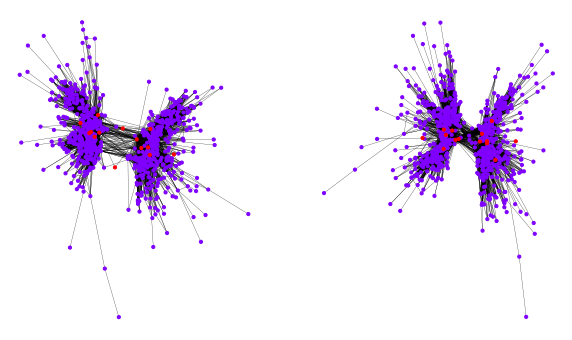

In [125]:
region1 = get_attribute_color(LCC1, 'dn_region')
region2 = get_attribute_color(LCC2, 'dn_region')

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(LCC1, node_size=10, width=0.25, pos=pos1, node_color=region1, ax=axes[0], cmap=plt.cm.rainbow)
nx.draw(LCC2, node_size=10, width=0.25, pos=pos2, node_color=region2, ax=axes[1], cmap=plt.cm.rainbow)

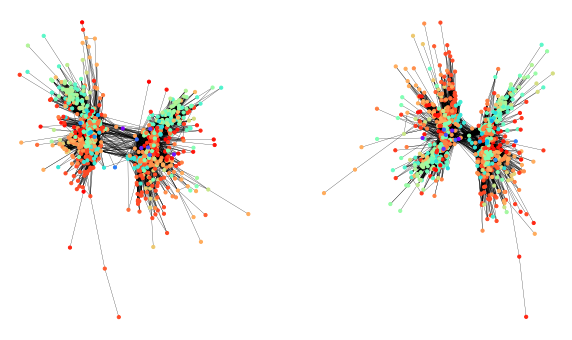

In [126]:
def add_general_name(G):
    fsnames = nx.get_node_attributes(G, 'dn_fsname')
    general_name = {k: v.split('_')[0] for k, v in fsnames.items()}
    nx.set_node_attributes(G, general_name, 'general_name')
    
add_general_name(LCC1)
add_general_name(LCC2)
genname1 = get_attribute_color(LCC1, 'general_name')
genname2 = get_attribute_color(LCC2, 'general_name')

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(LCC1, node_size=10, width=0.25, pos=pos1, node_color=genname1, ax=axes[0], cmap=plt.cm.rainbow)
nx.draw(LCC2, node_size=10, width=0.25, pos=pos2, node_color=genname2, ax=axes[1], cmap=plt.cm.rainbow)

# Nodes in the same area seem to appear together. 
# Can we cluster them accurately?
